In [1]:
pip install lightgbm xgboost catboost ngboost

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 9.6 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=3bdd7af3f3da8247d87911b3abf4cbf7abebb4e2e9b8673bac28806950352e62
  Stored in directory: /root/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma


In [ ]:

# Prediction Methods:
#   M1 Single-Stage LGBM (log-target) + causal histories (baseline)
#   M2 CRR++ (KMeans-on-train + router + per-family experts)
#   M3 Scale-Bucket Experts (train-quantiles → per-bucket models)
#   M4 Recency Ensemble (full + recent models; train-only gates)
# All components are carefully written to avoid data leakage.


import tarfile, pathlib, warnings, time, gc, math
from dataclasses import dataclass
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import spearmanr

from lightgbm import LGBMRegressor, early_stopping, log_evaluation

warnings.filterwarnings("ignore")
RNG = 42
np.random.seed(RNG)

# ---------------------------
# I/O
# ---------------------------
ARCHIVES = [
    "/content/pai_group_tag_table.tar.gz",
    "/content/pai_job_table.tar.gz",
    "/content/pai_task_table.tar.gz",
]
EXTRACT_DIR = pathlib.Path("/content/extracted")

def extract_archives():
    EXTRACT_DIR.mkdir(parents=True, exist_ok=True)
    for gz in ARCHIVES:
        with tarfile.open(gz, mode="r:gz") as tar:
            tar.extractall(path=EXTRACT_DIR)

@dataclass
class Tables:
    job:  pd.DataFrame
    task: pd.DataFrame
    gtag: pd.DataFrame

def load_tables() -> Tables:
    job_cols  = ["job_name","inst_id","user","status","start_time","end_time"]
    task_cols = ["job_name","task_name","inst_num","status","start_time","end_time",
                 "plan_cpu","plan_mem","plan_gpu","gpu_type"]
    grp_cols  = ["inst_id","user_from_group_table","gpu_type_spec","group","workload"]

    job  = pd.read_csv(EXTRACT_DIR/"pai_job_table.csv",  header=None, names=job_cols,  low_memory=False)
    task = pd.read_csv(EXTRACT_DIR/"pai_task_table.csv", header=None, names=task_cols, low_memory=False)
    gtag = pd.read_csv(EXTRACT_DIR/"pai_group_tag_table.csv", header=None, names=grp_cols,  low_memory=False)

    job  = job[job.status=="Terminated"].copy()
    task = task[task.status=="Terminated"].copy()

    # numeric times
    for df in (job, task):
        df["start_time"] = pd.to_numeric(df["start_time"], errors="coerce")
        df["end_time"]   = pd.to_numeric(df["end_time"],   errors="coerce")

    # drop NaNs, coerce numeric resources
    job.dropna(subset=["start_time","end_time"], inplace=True)
    for c in ["inst_num","plan_cpu","plan_mem","plan_gpu"]:
        task[c] = pd.to_numeric(task[c], errors="coerce").fillna(0)

    # task span (rolled-up instance intervals within each task)
    tspan = (task.groupby(["job_name","task_name"])
                  .agg(s_t=("start_time","min"),
                       e_t=("end_time","max"),
                       inst_num=("inst_num","sum"),
                       plan_cpu=("plan_cpu","sum"),
                       plan_mem=("plan_mem","sum"),
                       plan_gpu=("plan_gpu","sum"))
                  .reset_index())
    tspan["d_t"] = (tspan["e_t"] - tspan["s_t"]).clip(lower=0)
    tspan = tspan[tspan["d_t"] > 0]

    # job label p_star = max task span; submit-time aggregates
    jspan = (tspan.groupby("job_name")
                  .agg(p_star=("d_t","max"),
                       total_inst_num=("inst_num","sum"),
                       total_plan_cpu=("plan_cpu","sum"),
                       total_plan_mem=("plan_mem","sum"),
                       total_plan_gpu=("plan_gpu","sum"),
                       num_tasks=("task_name","nunique"))
                  .reset_index())

    base = (job[["job_name","inst_id","user","start_time"]]
            .merge(jspan, on="job_name", how="inner"))
    base = base[base["p_star"] > 0].copy()
    base.rename(columns={"start_time":"submit_time"}, inplace=True)

    # submit-time metadata
    gkeep = gtag[["inst_id","group","workload","gpu_type_spec"]].copy()
    base = base.merge(gkeep, on="inst_id", how="left")
    for c in ["group","workload","gpu_type_spec","user"]:
        base[c] = base[c].fillna("Unknown").astype(str)

    # clean
    del task, tspan, gtag
    gc.collect()

    return Tables(job=base, task=None, gtag=gkeep)

# ---------------------------
# Split & Metrics
# ---------------------------
def time_split(df: pd.DataFrame, train_frac=0.70, val_frac=0.15):
    qt = df["submit_time"].quantile([train_frac, train_frac+val_frac]).values
    t_train, t_val = int(qt[0]), int(qt[1])
    idx_tr = df.index[df["submit_time"] < t_train]
    idx_va = df.index[(df["submit_time"] >= t_train) & (df["submit_time"] < t_val)]
    idx_te = df.index[df["submit_time"] >= t_val]
    return (idx_tr, idx_va, idx_te), (t_train, t_val)

def metrics(y_true, y_pred) -> Dict[str, float]:
    y_true = np.asarray(y_true).clip(min=1e-9)
    y_pred = np.asarray(y_pred).clip(min=1e-9)
    mae   = float(mean_absolute_error(y_true, y_pred))
    rmsle = float(np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred))))
    rel   = np.abs(y_pred - y_true) / y_true
    cov25 = float(100.0*np.mean(rel <= 0.25))
    cov50 = float(100.0*np.mean(rel <= 0.50))
    rho   = float(spearmanr(y_true, y_pred)[0]) if len(y_true) > 1 else np.nan
    return {"MAE": mae, "RMSLE": rmsle, "Cov25": cov25, "Cov50": cov50, "Spearman": rho}

def print_metrics(tag, m):
    print(f"[{tag}]  Cov@25% {m['Cov25']:.1f}% | Cov@50% {m['Cov50']:.1f}% "
          f"| RMSLE {m['RMSLE']:.3f} | MAE {m['MAE']:.1f} | ρ {m['Spearman']:.3f}")

# ---------------------------
# Leakage‑free Feature Layer
# ---------------------------
def add_core_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # numeric safety
    for c in ["total_inst_num","total_plan_cpu","total_plan_mem","total_plan_gpu","num_tasks"]:
        df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0)

    # log1p & ratios
    for c in ["total_plan_cpu","total_plan_gpu","total_plan_mem","total_inst_num","num_tasks"]:
        df[f"log1p_{c}"] = np.log1p(df[c])
    df["cpu_per_inst"]   = df["total_plan_cpu"] / np.maximum(1.0, df["total_inst_num"])
    df["mem_per_gpu"]    = df["total_plan_mem"] / np.maximum(1.0, df["total_plan_gpu"])
    df["tasks_per_inst"] = df["num_tasks"]      / np.maximum(1.0, df["total_inst_num"])

    # temporal cyclic: hour-of-week (UTC seconds in trace)
    hour = ((df["submit_time"]//3600) % 24).astype(int)
    wday = (((df["submit_time"]//3600)//24) % 7).astype(int)
    how  = (wday*24 + hour).astype(int)
    df["hour"] = hour; df["wday"] = wday; df["how"] = how
    df["sin24"]  = np.sin(2*np.pi*hour/24.0)
    df["cos24"]  = np.cos(2*np.pi*hour/24.0)
    df["sin168"] = np.sin(2*np.pi*how/168.0)
    df["cos168"] = np.cos(2*np.pi*how/168.0)
    return df

def add_causal_histories(df: pd.DataFrame, t_train: int) -> Tuple[pd.DataFrame, float]:
    """
    Build causal (shifted) group/user histories on y_log=log1p(p_star).
    EB prior μ0 computed **on training time range only** to avoid leakage.
    """
    df = df.sort_values("submit_time").reset_index(drop=True).copy()
    df["y_log"] = np.log1p(df["p_star"].clip(lower=0))

    # EB prior on TRAIN time slice only
    mu0 = df.loc[df["submit_time"] < t_train, "y_log"].mean()
    if not np.isfinite(mu0): mu0 = df["y_log"].mean()

    # Efficient expanding mean/count via cumsum/cumcount (shifted)
    for key in ["group","user"]:
        pref = "grp" if key=="group" else "usr"
        grp  = df.groupby(key)
        csum = grp["y_log"].cumsum().shift(1)
        cnt  = grp.cumcount()  # already 0..(n-1), acts as shifted count
        df[f"{pref}_hist_mean"]  = (csum / cnt.replace(0, np.nan)).fillna(mu0)
        df[f"{pref}_hist_count"] = cnt.astype(float)

        last_ts = grp["submit_time"].shift(1)
        df[f"{pref}_dt_prev_log1p"] = np.log1p((df["submit_time"] - last_ts).fillna(0))

    # small rolling means on group (shifted)
    for w in (3,5,10):
        df[f"grp_roll_mean_w{w}"] = (df.groupby("group")["y_log"]
                                       .apply(lambda s: s.shift(1).rolling(w, min_periods=1).mean())
                                       .reset_index(level=0, drop=True).fillna(mu0))
    # EB shrinkage (toward μ0) for group means
    n  = df["grp_hist_count"].values
    mu = df["grp_hist_mean"].values
    lam = 10.0
    df["grp_mean_eb"] = (n*mu + lam*mu0) / (n + lam)

    return df, float(mu0)

def fit_scale_buckets(train_s: pd.Series, qs: List[float]):
    edges = np.quantile(train_s, qs).tolist()
    def bucketize(s):
        return np.searchsorted(edges, s, side="right").astype(int)
    return edges, bucketize

def build_feature_table(df_raw: pd.DataFrame, idx_tr: pd.Index, t_train: int):
    """
    Returns df with all (leakage‑free) features + list of columns to feed models.
    """
    df = add_core_features(df_raw)

    # causal histories (EB prior from training time range)
    df, mu0 = add_causal_histories(df, t_train)

    # scale buckets (train-only edges)
    inst_edges, inst_bucketize = fit_scale_buckets(df.loc[idx_tr,"total_inst_num"], [0.5,0.9,0.99])
    gpu_edges,  gpu_bucketize  = fit_scale_buckets(df.loc[idx_tr,"total_plan_gpu"], [0.5,0.9,0.99])
    df["inst_bucket"]  = inst_bucketize(df["total_inst_num"])
    df["gpu_bucket"]   = gpu_bucketize(df["total_plan_gpu"])
    df["scale_bucket"] = np.maximum(df["inst_bucket"], df["gpu_bucket"])

    # numericalized submit-time categories (no label-fit on test; safe deterministic codes)
    # We purposely avoid fitting encoders on full data; codes are derived by pandas 'category'
    # but applied **only using values present**; unknowns become -1 by map_from_train.
    def map_from_train(series: pd.Series, train_idx: pd.Index):
        cats = pd.Index(series.loc[train_idx].astype(str).unique())
        mapping = {c:i for i,c in enumerate(cats)}
        return series.astype(str).map(mapping).fillna(len(mapping)).astype(int)

    for c in ["user","group","workload","gpu_type_spec"]:
        df[f"{c}_code"] = map_from_train(df[c], idx_tr)

    FEATURES = [
        # resources / logs / ratios
        "log1p_total_plan_cpu","log1p_total_plan_gpu","log1p_total_plan_mem",
        "log1p_total_inst_num","log1p_num_tasks",
        "cpu_per_inst","mem_per_gpu","tasks_per_inst",
        # temporal (cyclic + discrete)
        "sin24","cos24","sin168","cos168","wday","hour",
        # scale
        "inst_bucket","gpu_bucket","scale_bucket",
        # causal histories
        "grp_hist_mean","grp_hist_count","grp_mean_eb","grp_roll_mean_w3","grp_roll_mean_w5","grp_roll_mean_w10",
        "grp_dt_prev_log1p","usr_hist_mean","usr_hist_count","usr_dt_prev_log1p",
        # submit-time codes
        "user_code","group_code","workload_code","gpu_type_spec_code",
    ]
    # sanitize
    df[FEATURES] = df[FEATURES].replace([np.inf,-np.inf], np.nan).fillna(0.0)
    return df, FEATURES, mu0

# ---------------------------
# M1 — Single‑Stage LGBM (log-target) + causal histories
# ---------------------------
def train_m1_single_stage(df, FEATS, idx_tr, idx_va, idx_te):
    y_log = np.log1p(df["p_star"].values)
    X_tr, y_tr = df.loc[idx_tr, FEATS], y_log[idx_tr]
    X_va, y_va = df.loc[idx_va, FEATS], y_log[idx_va]
    X_te, y_te = df.loc[idx_te, FEATS], df.loc[idx_te, "p_star"].values

    # monotone constraints for any subset of features we expect to be non-decreasing
    mono_features = ["log1p_total_inst_num","log1p_total_plan_gpu","log1p_num_tasks"]
    mono_vec = [1 if f in mono_features else 0 for f in FEATS]
    try:
        model = LGBMRegressor(
            n_estimators=800, learning_rate=0.05, num_leaves=63,
            min_child_samples=20, subsample=0.8, colsample_bytree=0.8,
            monotone_constraints=mono_vec, random_state=RNG, n_jobs=-1
        )
    except TypeError:
        model = LGBMRegressor(
            n_estimators=800, learning_rate=0.05, num_leaves=63,
            min_child_samples=20, subsample=0.8, colsample_bytree=0.8,
            random_state=RNG, n_jobs=-1
        )

    model.fit(X_tr, y_tr,
              eval_set=[(X_va, y_va)],
              callbacks=[early_stopping(50, verbose=False), log_evaluation(0)])
    yhat = np.expm1(model.predict(X_te)).clip(min=0)
    m = metrics(y_te, yhat)
    return m, yhat

# ---------------------------
# M2 — CRR++ (KMeans on train + router + per-family experts)
# ---------------------------
def train_m2_crr_plus(df, FEATS, idx_tr, idx_va, idx_te, K=5, min_family=1500):
    y_log = np.log1p(df["p_star"].values)
    X_tr, y_tr = df.loc[idx_tr, FEATS].copy(), y_log[idx_tr]
    X_va, y_va = df.loc[idx_va, FEATS].copy(), y_log[idx_va]
    X_te, y_te = df.loc[idx_te, FEATS].copy(), df.loc[idx_te, "p_star"].values

    scaler = StandardScaler().fit(X_tr.values)                 # fit on TRAIN only
    Z_tr = scaler.transform(X_tr.values)
    Z_va = scaler.transform(X_va.values)
    Z_te = scaler.transform(X_te.values)

    kmeans = KMeans(n_clusters=K, n_init=10, random_state=RNG).fit(Z_tr)  # train only
    fam_tr = kmeans.labels_
    fam_va = kmeans.predict(Z_va)
    fam_te = kmeans.predict(Z_te)

    router = RandomForestClassifier(n_estimators=150, max_depth=12,
                                    class_weight="balanced", n_jobs=-1, random_state=RNG)
    router.fit(Z_tr, fam_tr)
    # fallback regressor
    fallback = LGBMRegressor(
        n_estimators=600, learning_rate=0.05, num_leaves=63,
        min_child_samples=20, subsample=0.8, colsample_bytree=0.8,
        random_state=RNG, n_jobs=-1
    )
    fallback.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], callbacks=[early_stopping(50, False), log_evaluation(0)])

    # per-family experts
    experts: Dict[int, LGBMRegressor] = {}
    for k in range(K):
        mask_tr = (fam_tr == k)
        if mask_tr.sum() < min_family:
            continue
        model = LGBMRegressor(
            n_estimators=600, learning_rate=0.05, num_leaves=63,
            min_child_samples=20, subsample=0.8, colsample_bytree=0.8,
            random_state=RNG+100+k, n_jobs=-1
        )
        mask_va = (fam_va == k)
        if mask_va.sum() >= 200:
            model.fit(X_tr[mask_tr], y_tr[mask_tr],
                      eval_set=[(X_va[mask_va], y_va[mask_va])],
                      callbacks=[early_stopping(50, False), log_evaluation(0)])
        else:
            model.fit(X_tr[mask_tr], y_tr[mask_tr])
        experts[k] = model

    # predict via router → expert/fallback
    fam_hat = router.predict(Z_te)
    y_pred_log = np.zeros(len(X_te), dtype=float)
    for i, k in enumerate(fam_hat):
        model = experts.get(k, fallback)
        y_pred_log[i] = model.predict(X_te.iloc[i:i+1])[0]
    yhat = np.expm1(y_pred_log).clip(min=0)
    m = metrics(y_te, yhat)
    return m, yhat

# ---------------------------
# M3 — Scale‑Bucket Experts (train quantiles → per‑bucket models)
# ---------------------------
def train_m3_scale_experts(df, FEATS, idx_tr, idx_va, idx_te, min_bucket=2000):
    """
    Build per-scale models using train‑only edges on (inst_num, plan_gpu).
    Fallback is a global model; test samples routed by their buckets.
    """
    X_tr = df.loc[idx_tr, FEATS]; y_tr = df.loc[idx_tr, "p_star"].values
    X_va = df.loc[idx_va, FEATS]; y_va = df.loc[idx_va, "p_star"].values
    X_te = df.loc[idx_te, FEATS]; y_te = df.loc[idx_te, "p_star"].values

    # global fallback (log-target)
    y_tr_log = np.log1p(y_tr); y_va_log = np.log1p(y_va)
    global_model = LGBMRegressor(
        n_estimators=500, learning_rate=0.05, num_leaves=63,
        min_child_samples=20, subsample=0.8, colsample_bytree=0.8,
        random_state=RNG, n_jobs=-1
    )
    global_model.fit(X_tr, y_tr_log,
                     eval_set=[(X_va, y_va_log)],
                     callbacks=[early_stopping(40, False), log_evaluation(0)])

    # train per scale_bucket (already computed with train-only edges)
    experts: Dict[int, LGBMRegressor] = {}
    for b in sorted(df.loc[idx_tr, "scale_bucket"].unique()):
        tr_mask = (df.loc[idx_tr, "scale_bucket"].values == b)
        if tr_mask.sum() < min_bucket:
            continue
        model = LGBMRegressor(
            n_estimators=400, learning_rate=0.05, num_leaves=63,
            min_child_samples=20, random_state=RNG+200+b, n_jobs=-1
        )
        va_mask = (df.loc[idx_va, "scale_bucket"].values == b)
        model.fit(X_tr[tr_mask], y_tr_log[tr_mask],
                  eval_set=[(X_va[va_mask], y_va_log[va_mask])] if va_mask.sum() >= 200 else None,
                  callbacks=[early_stopping(30, False), log_evaluation(0)] if va_mask.sum() >= 200 else None)
        experts[b] = model

    # route test rows by their bucket
    buckets_te = df.loc[idx_te, "scale_bucket"].values
    y_pred_log = global_model.predict(X_te)
    for b, model in experts.items():
        mask = (buckets_te == b)
        if mask.any():
            y_pred_log[mask] = model.predict(X_te[mask])
    yhat = np.expm1(y_pred_log).clip(min=0)
    m = metrics(y_te, yhat)
    return m, yhat

# ---------------------------
# M4 — Recency Ensemble (train-only “recent window”)
# ---------------------------
def train_m4_recency_ensemble(df, FEATS, idx_tr, idx_va, idx_te, recent_q=0.70, mix=0.30):
    """
    Two log-target models:
      - 'full' on all training;
      - 'recent' on the last (recent_q..1.0) fraction of training time.
    Final prediction = (1-mix)*full + mix*recent (no test labels, no peeking).
    """
    y_tr_log = np.log1p(df.loc[idx_tr, "p_star"].values)
    y_va_log = np.log1p(df.loc[idx_va, "p_star"].values)
    y_te     = df.loc[idx_te, "p_star"].values

    X_tr = df.loc[idx_tr, FEATS].values
    X_va = df.loc[idx_va, FEATS].values
    X_te = df.loc[idx_te, FEATS].values

    # full model
    full = LGBMRegressor(
        n_estimators=500, learning_rate=0.04, num_leaves=63,
        min_child_samples=60, subsample=0.8, colsample_bytree=0.8,
        reg_alpha=0.2, reg_lambda=0.8, random_state=RNG, n_jobs=-1
    )
    full.fit(X_tr, y_tr_log, eval_set=[(X_va, y_va_log)],
             callbacks=[early_stopping(40, False), log_evaluation(0)])

    # recent model (train-only time window)
    t_cut = df.loc[idx_tr, "submit_time"].quantile(recent_q)
    tr_recent_mask = df.loc[idx_tr, "submit_time"].values >= t_cut
    if tr_recent_mask.sum() >= 1000:
        recent = LGBMRegressor(
            n_estimators=300, learning_rate=0.05, num_leaves=31,
            min_child_samples=40, random_state=RNG+1, n_jobs=-1
        )
        recent.fit(X_tr[tr_recent_mask], y_tr_log[tr_recent_mask],
                   eval_set=[(X_va, y_va_log)],
                   callbacks=[early_stopping(30, False), log_evaluation(0)])
        y_full   = np.expm1(full.predict(X_te))
        y_recent = np.expm1(recent.predict(X_te))
        yhat = ((1.0-mix)*y_full + mix*y_recent).clip(min=0)
    else:
        # not enough recent data, fallback to full model
        yhat = np.expm1(full.predict(X_te)).clip(min=0)

    m = metrics(y_te, yhat)
    return m, yhat

# ---------------------------
# Driver
# ---------------------------
def run_all_methods_no_leakage():
    print("=== PAI TRACE — FOUR LEAKAGE‑FREE METHODS ===")
    t0 = time.time()
    extract_archives()
    tbl = load_tables()
    df_raw = tbl.job.copy()
    print(f"Loaded jobs: {len(df_raw):,}")

    splits, (t_train, t_val) = time_split(df_raw, train_frac=0.70, val_frac=0.15)
    idx_tr, idx_va, idx_te = splits
    print(f"Split sizes  | train {len(idx_tr):,} | val {len(idx_va):,} | test {len(idx_te):,}")
    print(f"Cut times    | train< {t_train} | val< {t_val}")

    # feature table (all computed leakage‑free)
    df, FEATS, mu0 = build_feature_table(df_raw, idx_tr, t_train)

    out = {}

    # M1
    m1, y1 = train_m1_single_stage(df, FEATS, idx_tr, idx_va, idx_te)
    print_metrics("M1 Single-Stage", m1); out["M1"] = (m1, y1)

    # M2
    m2, y2 = train_m2_crr_plus(df, FEATS, idx_tr, idx_va, idx_te)
    print_metrics("M2 CRR++", m2); out["M2"] = (m2, y2)

    # M3
    m3, y3 = train_m3_scale_experts(df, FEATS, idx_tr, idx_va, idx_te)
    print_metrics("M3 Scale-Experts", m3); out["M3"] = (m3, y3)

    # M4
    m4, y4 = train_m4_recency_ensemble(df, FEATS, idx_tr, idx_va, idx_te)
    print_metrics("M4 Recency-Ensemble", m4); out["M4"] = (m4, y4)

    print(f"\nTotal wall time: {time.time()-t0:.1f}s")
    return df, idx_te, out

# If you want to run immediately:
df, idx_te, results = run_all_methods_no_leakage()
# Each entry in `results` is (metrics_dict, y_pred_array) for the test split (idx_te).


=== PAI TRACE — FOUR LEAKAGE‑FREE METHODS ===
Loaded jobs: 732,355
Split sizes  | train 512,647 | val 109,854 | test 109,854
Cut times    | train< 5020579 | val< 5764872
[M1 Single-Stage]  Cov@25% 39.9% | Cov@50% 61.3% | RMSLE 1.002 | MAE 3008.6 | ρ 0.885
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[600]	valid_0's l2: 1.08146
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[593]	valid_0's l2: 0.707229
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[96]	valid_0's l2: 1.34638
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[372]	valid_0's l2: 0.712662
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[115]	valid_0's l2: 1.26164
[M2 CRR++]  Cov@25% 40.0% | Cov@50% 61.8% | RMSLE 1.016 | MAE 2973.6 | ρ 0.882
Training until val

In [ ]:
# ============================================================
# PAI TRACE JOB DURATION PREDICTION — FIXED & RUNNABLE
# ============================================================
import tarfile, pathlib, warnings, gc, time
import numpy as np
import pandas as pd

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import Ridge
from scipy.stats import spearmanr

from lightgbm import LGBMRegressor, LGBMClassifier, early_stopping, log_evaluation

warnings.filterwarnings("ignore")
np.random.seed(42)
RANDOM_STATE = 42

# ----------------------------
# 0) IO / Config
# ----------------------------
ARCHIVES = [
    "/content/pai_group_tag_table.tar.gz",
    "/content/pai_job_table.tar.gz",
    "/content/pai_task_table.tar.gz",
]
EXTRACT_DIR = pathlib.Path("/content/extracted")


def extract_archives():
    """Extract tar.gz archives."""
    EXTRACT_DIR.mkdir(parents=True, exist_ok=True)
    for gz in ARCHIVES:
        with tarfile.open(gz, mode="r:gz") as tar:
            tar.extractall(path=EXTRACT_DIR)
    print(f"[IO] Extracted files to {EXTRACT_DIR}")


# ----------------------------
# 1) Load & compute correct p_star and resource totals
# ----------------------------
def load_tables():
    """Load PAI CSVs and compute job-level label p_star and resource totals correctly.

    - p_star uses the task table envelope: max(end_time) - min(start_time)
    - CPU/GPU in task table are per-instance percentages; convert to counts first, then × inst_num
    """
    job_cols   = ["job_name", "inst_id", "user", "status", "start_time", "end_time"]
    task_cols  = ["job_name", "task_name", "inst_num", "status", "start_time", "end_time",
                  "plan_cpu", "plan_mem", "plan_gpu", "gpu_type"]
    # In some releases this column is named `user_from_group_table`; we don't use it below.
    group_cols = ["inst_id", "user_from_group_table", "gpu_type_spec", "group", "workload"]

    job  = pd.read_csv(EXTRACT_DIR / "pai_job_table.csv",  header=None, names=job_cols,  low_memory=False)
    task = pd.read_csv(EXTRACT_DIR / "pai_task_table.csv", header=None, names=task_cols, low_memory=False)
    gtag = pd.read_csv(EXTRACT_DIR / "pai_group_tag_table.csv", header=None, names=group_cols, low_memory=False)

    # Keep only finished
    job  = job[job.status  == "Terminated"].copy()
    task = task[task.status == "Terminated"].copy()

    # Timestamps to numeric
    for df in (job, task):
        df["start_time"] = pd.to_numeric(df["start_time"], errors="coerce")
        df["end_time"]   = pd.to_numeric(df["end_time"],   errors="coerce")

    # Convert resource fields to numeric
    for c in ["plan_cpu", "plan_gpu", "plan_mem", "inst_num"]:
        task[c] = pd.to_numeric(task[c], errors="coerce")

    # --- Convert per-instance % to counts, then scale by inst_num (per-task totals) ---
    # CPU: 600.0 -> 6 vCPU; GPU: 50.0 -> 0.5 GPU; Mem: already an absolute amount per instance (GB)
    task["cpu_per_inst"] = task["plan_cpu"] / 100.0
    task["gpu_per_inst"] = task["plan_gpu"] / 100.0
    task["mem_per_inst"] = task["plan_mem"]           # units as in dataset (GB)

    task["cpu_total"] = task["cpu_per_inst"] * task["inst_num"]
    task["gpu_total"] = task["gpu_per_inst"] * task["inst_num"]
    task["mem_total"] = task["mem_per_inst"] * task["inst_num"]

    # --- Job envelope makespan p_star ---
    job_span = (task.groupby("job_name")
                    .agg(min_start_time=("start_time","min"),
                         max_end_time=("end_time","max"),
                         total_inst_num=("inst_num","sum"),
                         total_plan_cpu=("cpu_total","sum"),   # cores
                         total_plan_mem=("mem_total","sum"),   # GB
                         total_plan_gpu=("gpu_total","sum"),   # GPUs
                         num_tasks=("task_name","nunique"))
                    .reset_index())
    job_span["p_star"] = (job_span["max_end_time"] - job_span["min_start_time"]).clip(lower=0)

    # Merge minimal job metadata + group tags
    base = job[["job_name","inst_id","user","start_time"]].merge(job_span, on="job_name", how="inner")
    base = base[base["p_star"] > 0].copy()

    base = base.merge(gtag[["inst_id","group","workload","gpu_type_spec"]],
                      on="inst_id", how="left")

    for c in ["group","workload","gpu_type_spec","user"]:
        base[c] = base[c].fillna("Unknown").astype(str)

    base.rename(columns={"start_time": "submit_time"}, inplace=True)

    # Cleanup
    del job, task, gtag, job_span
    gc.collect()
    return base


# ----------------------------
# 2) Time-based splitting
# ----------------------------
def time_split(df, train_frac=0.70, val_frac=0.15):
    """Split indices by submit_time quantiles (train/val/test)."""
    qt = df["submit_time"].quantile([train_frac, train_frac + val_frac]).values
    t_train, t_val = int(qt[0]), int(qt[1])
    idx_tr = df.index[df["submit_time"] < t_train]
    idx_va = df.index[(df["submit_time"] >= t_train) & (df["submit_time"] < t_val)]
    idx_te = df.index[df["submit_time"] >= t_val]
    return (idx_tr, idx_va, idx_te), (t_train, t_val)


# ----------------------------
# 3) Feature engineering
# ----------------------------
def fit_label_encoder_from_train(train_series):
    """TRAIN-ONLY label encoder (unseen -> -1)."""
    classes = pd.Index(train_series.dropna().unique().tolist())
    mapping = {v: i for i, v in enumerate(classes)}
    def _transform(s):
        return s.map(mapping).fillna(-1).astype(int)
    return _transform


def make_signatures(df, idx_tr):
    """TRAIN-ONLY signatures and signature stats (with EB on log scale)."""
    df = df.copy()
    train_df = df.loc[idx_tr]

    def qbin(col, q=10):
        # Train-only bin edges; clip low values to avoid degenerate edges
        edges = np.quantile(train_df[col].clip(lower=1e-6), np.linspace(0,1,q+1))
        edges[0], edges[-1] = -np.inf, np.inf
        return np.searchsorted(edges, df[col].values, side="right") - 1

    # Discretize resource totals (job-level)
    df["cpu_b"]  = qbin("total_plan_cpu", 10)
    df["gpu_b"]  = qbin("total_plan_gpu", 10)
    df["mem_b"]  = qbin("total_plan_mem", 10)
    df["inst_b"] = qbin("total_inst_num", 10)

    # Signature: user|group|workload|cpu_b-gpu_b-mem_b-inst_b
    df["task_signature"] = (
        df["user"].astype(str) + "|" + df["group"].astype(str) + "|" + df["workload"].astype(str)
        + "|" + df["cpu_b"].astype(str) + "-" + df["gpu_b"].astype(str)
        + "-" + df["mem_b"].astype(str) + "-" + df["inst_b"].astype(str)
    )

    # Train-only signature stats on p_star
    sig_stats = (df.loc[idx_tr].groupby("task_signature")["p_star"]
                   .agg(sig_mean="mean",
                        sig_median="median",
                        sig_std="std",
                        sig_count="count",
                        sig_q25=lambda x: x.quantile(0.25),
                        sig_q75=lambda x: x.quantile(0.75))
                   .reset_index())

    # Log transforms of stats
    for c in ["sig_mean","sig_median","sig_q25","sig_q75"]:
        sig_stats[c + "_log"] = np.log1p(sig_stats[c])

    # Signature-level EB shrinkage ON LOG SCALE
    mu0_train = np.log1p(df.loc[idx_tr, "p_star"]).mean()
    n_s = sig_stats["sig_count"].astype(float)
    mu_s = sig_stats["sig_mean_log"].astype(float)
    lambda_shrink = 5.0
    sig_stats["sig_mean_shrink"] = (n_s * mu_s + lambda_shrink * mu0_train) / (n_s + lambda_shrink)

    # Merge stats back
    df = df.merge(sig_stats, on="task_signature", how="left")
    return df


def add_basic_features(df):
    """Basic features: logs, per-instance ratios, calendar features."""
    df = df.copy()

    # Logs of totals
    for c in ["total_plan_cpu","total_plan_gpu","total_plan_mem","total_inst_num","num_tasks"]:
        df[f"log_{c}"] = np.log1p(df[c].clip(lower=0))

    # Per-instance ratios (well-defined after correct aggregation)
    df["cpu_per_inst"]   = df["total_plan_cpu"] / np.maximum(1.0, df["total_inst_num"])
    df["gpu_per_inst"]   = df["total_plan_gpu"] / np.maximum(1.0, df["total_inst_num"])
    df["mem_per_inst"]   = df["total_plan_mem"] / np.maximum(1.0, df["total_inst_num"])
    df["tasks_per_inst"] = df["num_tasks"]      / np.maximum(1.0, df["total_inst_num"])

    # Temporal
    hour = ((df["submit_time"] // 3600) % 24).astype(int)
    dow  = ((df["submit_time"] // 86400) % 7).astype(int)
    df["hour"] = hour
    df["dow"]  = dow
    df["sin_hour"]   = np.sin(2*np.pi*hour/24.0)
    df["cos_hour"]   = np.cos(2*np.pi*hour/24.0)
    df["is_weekend"] = (df["dow"] >= 5).astype(int)
    return df


def add_causal_histories(df, time_col="submit_time"):
    """Strictly causal histories with WITHIN-group shift(1)."""
    df = df.sort_values(time_col).reset_index(drop=True).copy()
    df["y_log"] = np.log1p(df["p_star"])

    for key, prefix in [("group","gro"), ("user","use")]:
        g = df.groupby(key)["y_log"]

        # Within-group shift(1)
        df[f"{prefix}_hist_mean"] = g.apply(
            lambda s: s.expanding().mean().shift(1)
        ).reset_index(level=0, drop=True)

        df[f"{prefix}_hist_count"] = g.apply(
            lambda s: s.expanding().count().shift(1)
        ).reset_index(level=0, drop=True)

        df[f"{prefix}_ewm"] = g.apply(
            lambda s: s.ewm(span=10, adjust=False).mean().shift(1)
        ).reset_index(level=0, drop=True)

        # Time since last submit (log-seconds)
        dt = df.groupby(key)[time_col].diff()
        df[f"{prefix}_dt_prev"] = np.log1p(dt).fillna(0)

    return df


def engineer_all_features(df, idx_tr):
    """Full feature pipeline with priors and flags."""
    df = add_basic_features(df)
    df = make_signatures(df, idx_tr)

    # Global prior on log scale
    mu0 = np.log1p(df.loc[idx_tr, "p_star"]).mean()

    # Histories (causal)
    df = add_causal_histories(df)

    # Group-level EB shrinkage on log scale (using historical mean)
    n   = df["gro_hist_count"].fillna(0.0)
    mu  = df["gro_hist_mean"].fillna(mu0)
    lam = 5.0
    df["grp_mean_eb"] = (n * mu + lam * mu0) / (n + lam)

    # Fill missing historical stats
    for c in ["gro_hist_mean","use_hist_mean","gro_ewm","use_ewm"]:
        df[c] = df[c].fillna(mu0)
    for c in ["gro_hist_count","use_hist_count","gro_dt_prev","use_dt_prev"]:
        df[c] = df[c].fillna(0.0)

    # Flags
    df["is_recurring"] = df["sig_count"].fillna(0) > 0

    # Global mean (log) for last-resort fallback
    df["global_mean"] = mu0
    return df


# ----------------------------
# 4) Metrics
# ----------------------------
def rmsle(y, yhat):
    y = np.maximum(y, 0); yhat = np.maximum(yhat, 0)
    return float(np.sqrt(mean_squared_error(np.log1p(y), np.log1p(yhat))))

def coverage_at(y, yhat, pct=0.25):
    y = np.maximum(y, 1e-12)
    rel = np.abs(yhat - y) / y
    return 100.0 * float(np.mean(rel <= pct))

def metrics(y, yhat):
    return dict(
        MAE=float(mean_absolute_error(y, yhat)),
        RMSLE=rmsle(y, yhat),
        Cov25=coverage_at(y, yhat, 0.25),
        Cov50=coverage_at(y, yhat, 0.50),
        Spearman=float(spearmanr(y, yhat).correlation) if np.std(y)>0 and np.std(yhat)>0 else np.nan
    )

def print_metrics(tag, y, yhat):
    m = metrics(y, yhat)
    print(f"[{tag:16s}]  Cov@25% {m['Cov25']:5.1f}% | Cov@50% {m['Cov50']:5.1f}% | "
          f"RMSLE {m['RMSLE']:.3f} | MAE {m['MAE']:7.1f} | ρ {m['Spearman']:.3f}")
    return m


# ----------------------------
# 5) Prepare matrices
# ----------------------------
def prepare_matrices(df, idx_tr, idx_va, idx_te):
    NUM_FEATS = [
        # resources/logs/ratios
        "log_total_plan_cpu","log_total_plan_gpu","log_total_plan_mem",
        "log_total_inst_num","log_num_tasks",
        "cpu_per_inst","gpu_per_inst","mem_per_inst","tasks_per_inst",
        # temporal
        "hour","dow","sin_hour","cos_hour","is_weekend",
        # signature stats
        "sig_mean_log","sig_median_log","sig_q25_log","sig_q75_log","sig_count","sig_mean_shrink",
        # histories
        "gro_hist_mean","gro_hist_count","gro_ewm","gro_dt_prev",
        "use_hist_mean","use_hist_count","use_ewm","use_dt_prev",
        # priors
        "grp_mean_eb",
    ]
    NUM_FEATS = [f for f in NUM_FEATS if f in df.columns]

    # TRAIN-ONLY encoders for categoricals
    for c in ["user","group","workload","gpu_type_spec"]:
        enc = fit_label_encoder_from_train(df.loc[idx_tr, c])
        df[f"{c}_enc"] = enc(df[c])
        NUM_FEATS.append(f"{c}_enc")

    Xtr = df.loc[idx_tr, NUM_FEATS].replace([np.inf,-np.inf], np.nan).fillna(0).values
    Xva = df.loc[idx_va, NUM_FEATS].replace([np.inf,-np.inf], np.nan).fillna(0).values
    Xte = df.loc[idx_te, NUM_FEATS].replace([np.inf,-np.inf], np.nan).fillna(0).values

    ytr_log = np.log1p(df.loc[idx_tr, "p_star"].values)
    yva_log = np.log1p(df.loc[idx_va, "p_star"].values)
    yte     = df.loc[idx_te, "p_star"].values
    return NUM_FEATS, Xtr, Xva, Xte, ytr_log, yva_log, yte


# ----------------------------
# 6) LGBM helper
# ----------------------------
def fit_lgbm(params, Xtr, ytr_log, Xva=None, yva_log=None, n_estimators=600, es=50):
    model = LGBMRegressor(n_estimators=n_estimators, random_state=RANDOM_STATE, **params)
    if Xva is not None and yva_log is not None:
        model.fit(Xtr, ytr_log,
                  eval_set=[(Xva, yva_log)],
                  callbacks=[early_stopping(es, verbose=False), log_evaluation(0)])
    else:
        model.fit(Xtr, ytr_log)
    return model


# ----------------------------
# 7) Methods
# ----------------------------
def method_cqr(Xtr, Xva, Xte, ytr_log, yva_log, df, idx_va, idx_te):
    """M1: Conformal-like quantiles + Ridge blender with explicit [L, Q0.5, U] and priors."""
    # Base L2
    base = fit_lgbm(dict(learning_rate=0.05, num_leaves=63, min_child_samples=20, subsample=0.8),
                    Xtr, ytr_log, Xva, yva_log)
    base_va = base.predict(Xva); base_te = base.predict(Xte)

    # Quantiles
    qL = fit_lgbm(dict(objective="quantile", alpha=0.1, learning_rate=0.05, num_leaves=63),
                  Xtr, ytr_log, Xva, yva_log, n_estimators=400, es=40)
    qM = fit_lgbm(dict(objective="quantile", alpha=0.5, learning_rate=0.05, num_leaves=63),
                  Xtr, ytr_log, Xva, yva_log, n_estimators=400, es=40)
    qU = fit_lgbm(dict(objective="quantile", alpha=0.9, learning_rate=0.05, num_leaves=63),
                  Xtr, ytr_log, Xva, yva_log, n_estimators=400, es=40)

    qL_va, qM_va, qU_va = qL.predict(Xva), qM.predict(Xva), qU.predict(Xva)
    qL_te, qM_te, qU_te = qL.predict(Xte), qM.predict(Xte), qU.predict(Xte)

    # Width on log scale
    r = np.maximum(qL_va - yva_log, yva_log - qU_va)
    k = np.quantile(np.maximum(r, 0.0), 0.60)
    L_va, U_va = qL_va - k, qU_va + k
    L_te, U_te = qL_te - k, qU_te + k

    # Clip the median to interval
    qM_clip_va = np.clip(qM_va, L_va, U_va)
    qM_clip_te = np.clip(qM_te, L_te, U_te)

    # Blender with priors
    Z_va = np.c_[
        L_va, qM_va, U_va,          # interval endpoints + raw median
        qM_clip_va,                 # clipped median
        base_va,                    # base L2
        df.loc[idx_va, "grp_mean_eb"].values,
        df.loc[idx_va, "sig_median_log"].fillna(df.loc[idx_va, "grp_mean_eb"]).values
    ]
    ridge = Ridge(alpha=1.0, fit_intercept=True, random_state=RANDOM_STATE)
    ridge.fit(Z_va, yva_log)

    Z_te = np.c_[
        L_te, qM_te, U_te,
        qM_clip_te,
        base_te,
        df.loc[idx_te, "grp_mean_eb"].values,
        df.loc[idx_te, "sig_median_log"].fillna(df.loc[idx_te, "grp_mean_eb"]).values
    ]
    yhat_log = ridge.predict(Z_te)
    return np.expm1(yhat_log).clip(min=0)


def method_hras(df, idx_te):
    """M3: HRAS via signature-level EB shrinkage + group EB + global fallback (all log-domain)."""
    pred_log = (df.loc[idx_te, "sig_mean_shrink"]
                .fillna(df.loc[idx_te, "grp_mean_eb"])
                .fillna(df.loc[idx_te, "global_mean"])
                .values)
    return np.expm1(pred_log).clip(min=0)


def method_isotonic(Xtr, Xva, Xte, ytr_log, yva_log):
    """M4: Quantile median + isotonic calibration (on log scale)."""
    qmed = fit_lgbm(dict(objective="quantile", alpha=0.5, learning_rate=0.05, num_leaves=63),
                    Xtr, ytr_log, Xva, yva_log, n_estimators=800, es=60)
    pred_va = qmed.predict(Xva)
    pred_te = qmed.predict(Xte)
    iso = IsotonicRegression(out_of_bounds="clip")
    iso.fit(pred_va, yva_log)
    yhat_log = iso.predict(pred_te)
    return np.expm1(yhat_log).clip(min=0)


def method_meta_stack(Xtr, Xva, Xte, ytr_log, yva_log, df, idx_va, idx_te):
    """M5: LGBM meta-learner on base predictions + dispersion + context (on log scale)."""
    base_models = []
    m1 = fit_lgbm(dict(learning_rate=0.05, num_leaves=63, min_child_samples=20, subsample=0.8),
                  Xtr, ytr_log, Xva, yva_log)
    base_models.append(m1)

    m2 = fit_lgbm(dict(learning_rate=0.03, num_leaves=127, min_child_samples=50,
                       reg_alpha=0.5, reg_lambda=1.0, subsample=0.7),
                  Xtr, ytr_log, Xva, yva_log, n_estimators=400)
    base_models.append(m2)

    m3 = fit_lgbm(dict(objective="quantile", alpha=0.5, learning_rate=0.05, num_leaves=63),
                  Xtr, ytr_log, Xva, yva_log, n_estimators=400)
    base_models.append(m3)

    m4 = fit_lgbm(dict(objective="huber", alpha=0.9, learning_rate=0.05, num_leaves=63),
                  Xtr, ytr_log, Xva, yva_log, n_estimators=400)
    base_models.append(m4)

    va_preds = np.column_stack([m.predict(Xva) for m in base_models])
    te_preds = np.column_stack([m.predict(Xte) for m in base_models])

    # Dispersion
    va_std = np.std(va_preds, axis=1).reshape(-1,1)
    te_std = np.std(te_preds, axis=1).reshape(-1,1)

    # Context priors
    va_ctx = np.column_stack([
        df.loc[idx_va, "grp_mean_eb"].values,
        df.loc[idx_va, "sig_median_log"].fillna(df.loc[idx_va, "grp_mean_eb"]).values
    ])
    te_ctx = np.column_stack([
        df.loc[idx_te, "grp_mean_eb"].values,
        df.loc[idx_te, "sig_median_log"].fillna(df.loc[idx_te, "grp_mean_eb"]).values
    ])

    Z_va = np.hstack([va_preds, va_std, va_ctx])
    Z_te = np.hstack([te_preds, te_std, te_ctx])

    meta = LGBMRegressor(n_estimators=200, learning_rate=0.05, num_leaves=31,
                         min_child_samples=30, random_state=RANDOM_STATE)
    meta.fit(Z_va, yva_log)
    yhat_log = meta.predict(Z_te)
    return np.expm1(yhat_log).clip(min=0)


def method_two_stage(Xtr, Xva, Xte, ytr_log, yva_log):
    """M6: Classify by duration tertiles then combine experts by class probabilities."""
    p30, p70 = np.percentile(ytr_log, [30, 70])
    y_class = np.zeros_like(ytr_log, dtype=int)
    y_class[ytr_log < p30] = 0
    y_class[(ytr_log >= p30) & (ytr_log < p70)] = 1
    y_class[ytr_log >= p70] = 2

    clf = LGBMClassifier(n_estimators=300, learning_rate=0.05, num_leaves=31,
                         min_child_samples=20, random_state=RANDOM_STATE)
    clf.fit(Xtr, y_class)
    probs_te = clf.predict_proba(Xte)

    experts = {}
    for c in range(3):
        mask = (y_class == c)
        if mask.sum() > 100:
            expert = LGBMRegressor(n_estimators=400, learning_rate=0.05, num_leaves=63,
                                   min_child_samples=20, random_state=RANDOM_STATE)
            expert.fit(Xtr[mask], ytr_log[mask])
            experts[c] = expert

    fallback = fit_lgbm(dict(learning_rate=0.05, num_leaves=63), Xtr, ytr_log, n_estimators=400)

    yhat_log = np.zeros(len(Xte))
    for c in range(3):
        model = experts.get(c, fallback)
        yhat_log += probs_te[:, c] * model.predict(Xte)
    return np.expm1(yhat_log).clip(min=0)


def method_recency(Xtr, Xva, Xte, ytr_log, yva_log, df, idx_tr, idx_va):
    """M7: Recency ensemble with validation-adaptive weights (inverse MAE)."""
    times_tr = df.loc[idx_tr, "submit_time"].values
    tmax, tmin = times_tr.max(), times_tr.min()
    # time-decay weights for full-history model
    time_w = np.exp(-0.5 * (tmax - times_tr) / (tmax - tmin + 1.0))

    models = []

    # Full history with time weights
    m1 = LGBMRegressor(n_estimators=400, learning_rate=0.05, num_leaves=63,
                       min_child_samples=20, random_state=RANDOM_STATE)
    m1.fit(Xtr, ytr_log, sample_weight=time_w)
    models.append(("full", m1))

    # Recent 50%
    cut50 = np.percentile(times_tr, 50)
    mask50 = times_tr >= cut50
    if mask50.sum() > 1000:
        m2 = fit_lgbm(dict(learning_rate=0.06, num_leaves=63),
                      Xtr[mask50], ytr_log[mask50], n_estimators=300)
        models.append(("recent_50", m2))

    # Recent 20%
    cut20 = np.percentile(times_tr, 80)
    mask20 = times_tr >= cut20
    if mask20.sum() > 500:
        m3 = fit_lgbm(dict(learning_rate=0.08, num_leaves=31),
                      Xtr[mask20], ytr_log[mask20], n_estimators=200)
        models.append(("recent_20", m3))

    # Validation-adaptive weights (inverse MAE on log scale)
    errs = []
    for name, model in models:
        pred_va = model.predict(Xva)
        errs.append(np.mean(np.abs(pred_va - yva_log)))
    errs = np.array(errs)
    w = 1.0 / (errs + 1e-2)
    w = w / w.sum()

    yhat_log = np.zeros(len(Xte))
    for i, (name, model) in enumerate(models):
        yhat_log += w[i] * model.predict(Xte)
    return np.expm1(yhat_log).clip(min=0)


# ----------------------------
# 8) Main
# ----------------------------
def main():
    print("=" * 78)
    print("PAI TRACE — JOB DURATION PREDICTION (FIXED)")
    print("=" * 78)

    t0 = time.time()
    print("\n[1/6] Extracting & loading ...")
    extract_archives()
    df = load_tables()
    print(f"  Loaded jobs: {len(df):,}")

    print("\n[2/6] Time-based splits ...")
    (idx_tr, idx_va, idx_te), (t_train, t_val) = time_split(df, 0.70, 0.15)
    print(f"  Train: {len(idx_tr):,}  (< {t_train})")
    print(f"  Val  : {len(idx_va):,}  ([{t_train}, {t_val}))")
    print(f"  Test : {len(idx_te):,}  (>= {t_val})")

    print("\n[3/6] Feature engineering ...")
    df = engineer_all_features(df, idx_tr)
    print(f"  Feature columns: {df.shape[1]}")

    print("\n[4/6] Preparing matrices ...")
    NUM_FEATS, Xtr, Xva, Xte, ytr_log, yva_log, yte = prepare_matrices(df, idx_tr, idx_va, idx_te)
    print(f"  #Features: {Xtr.shape[1]}")

    print("\n[5/6] Running methods ...")
    results, predictions = {}, {}

    print("  M1: CQR ...", end=" ")
    yhat = method_cqr(Xtr, Xva, Xte, ytr_log, yva_log, df, idx_va, idx_te)
    results["M1 CQR"] = print_metrics("M1 CQR", yte, yhat); predictions["M1"] = yhat

    print("  M3: HRAS ...", end=" ")
    yhat = method_hras(df, idx_te)
    results["M3 HRAS"] = print_metrics("M3 HRAS", yte, yhat); predictions["M3"] = yhat

    print("  M4: Isotonic ...", end=" ")
    yhat = method_isotonic(Xtr, Xva, Xte, ytr_log, yva_log)
    results["M4 Iso"] = print_metrics("M4 Iso", yte, yhat); predictions["M4"] = yhat

    print("  M5: Meta-Stack ...", end=" ")
    yhat = method_meta_stack(Xtr, Xva, Xte, ytr_log, yva_log, df, idx_va, idx_te)
    results["M5 Meta"] = print_metrics("M5 Meta", yte, yhat); predictions["M5"] = yhat

    print("  M6: Two-Stage ...", end=" ")
    yhat = method_two_stage(Xtr, Xva, Xte, ytr_log, yva_log)
    results["M6 Two"] = print_metrics("M6 Two", yte, yhat); predictions["M6"] = yhat

    print("  M7: Recency ...", end=" ")
    yhat = method_recency(Xtr, Xva, Xte, ytr_log, yva_log, df, idx_tr, idx_va)
    results["M7 Rec"] = print_metrics("M7 Rec", yte, yhat); predictions["M7"] = yhat

    # Recurring vs new signatures
    print("\n[6/6] Recurring vs new signatures ...")
    rec_mask = df.loc[idx_te, "is_recurring"].values.astype(bool)
    new_mask = ~rec_mask
    print(f"  Recurring: {rec_mask.sum():,} ({100*rec_mask.mean():.1f}%)")
    print(f"  New      : {new_mask.sum():,} ({100*new_mask.mean():.1f}%)")
    if rec_mask.any():
        for k, yhat in predictions.items():
            m = metrics(yte[rec_mask], yhat[rec_mask])
            print(f"  [{k:8s}] on Recurring  Cov@25% {m['Cov25']:5.1f}% | Cov@50% {m['Cov50']:5.1f}% | RMSLE {m['RMSLE']:.3f} | MAE {m['MAE']:7.1f}")

    print("\n" + "="*78)
    print(f"Total wall time: {time.time()-t0:.1f}s")
    print("="*78)
    return df, idx_te, predictions, results


if __name__ == "__main__":
    df, idx_te, predictions, results = main()


PAI TRACE — JOB DURATION PREDICTION (FIXED)

[1/6] Extracting & loading ...
[IO] Extracted files to /content/extracted
  Loaded jobs: 732,355

[2/6] Time-based splits ...
  Train: 512,647  (< 5020579)
  Val  : 109,854  ([5020579, 5764872))
  Test : 109,854  (>= 5764872)

[3/6] Feature engineering ...
  Feature columns: 57

[4/6] Preparing matrices ...
  #Features: 33

[5/6] Running methods ...
  M1: CQR ... [LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048223 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5583
[LightGBM] [Info] Number of data points in the train set: 512647, number of used features: 33
[LightGBM] [Info] Start training from score 6.602821
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034332 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not

In [ ]:
# MAX-STRETCH (1|r,pmtn|S_max) — Optimized Fast Evaluation (ICLR-safe)
# This revision ensures OPT's max/OPT prints as exactly 1.000 by
# normalizing to the realized max stretch of EDF at S* (no slack).


from typing import Dict, Tuple, Optional
import numpy as np, heapq, time, math

EPS = 1e-9

# --------------------------- Preparation ----------------------------
def _prepare_jobs(
    df,
    idx_te,
    y_pred: np.ndarray,
    sample_size: Optional[int] = 5000,
    seed: int = 42,
    clip_ratio: Optional[Tuple[float,float]] = (0.1, 10.0),
):
    cols = ["submit_time", "p_star"]
    te = df.loc[idx_te, cols].reset_index(drop=True).copy()

    n_all = len(te)
    y_pred = np.asarray(y_pred[:n_all], dtype=np.float64)

    if sample_size and sample_size < n_all:
        rng = np.random.RandomState(seed)
        pick = np.sort(rng.choice(n_all, size=sample_size, replace=False))
        te = te.iloc[pick].copy()
        y_pred = y_pred[pick]

    sort_idx = np.argsort(te["submit_time"].values)
    te = te.iloc[sort_idx].reset_index(drop=True)
    y_pred = y_pred[sort_idx]

    r0 = float(te["submit_time"].iloc[0])
    r = te["submit_time"].to_numpy(dtype=np.float64) - r0
    p = np.maximum(te["p_star"].to_numpy(dtype=np.float64), 1.0)
    q = np.maximum(y_pred.astype(np.float64), 1.0)

    if clip_ratio:
        lo, hi = clip_ratio
        q = np.clip(q, lo * p, hi * p)

    return r, p, q

# ------------------------------ Metrics -----------------------------
def _stretch_array(r: np.ndarray, C: np.ndarray, p: np.ndarray) -> np.ndarray:
    return np.maximum((C - r) / np.maximum(p, EPS), 1.0)

def _compute_metrics(r: np.ndarray, C: np.ndarray, p: np.ndarray, normS: float) -> Dict:
    s = _stretch_array(r, C, p)
    tau = 10.0
    bsld = (C - r) / np.maximum(p, tau)
    return {
        "n": int(s.size),
        "max": float(np.max(s)),
        "p99": float(np.percentile(s, 99)),
        "p95": float(np.percentile(s, 95)),
        "p90": float(np.percentile(s, 90)),
        "median": float(np.median(s)),
        "mean": float(np.mean(s)),
        "max_over_OPT": float(np.max(s) / normS),
        "p99_over_OPT": float(np.percentile(s, 99) / normS),
        "p95_over_OPT": float(np.percentile(s, 95) / normS),
        "med_over_OPT": float(np.median(s) / normS),
        "bsld10_max": float(np.max(bsld)),
        "bsld10_p99": float(np.percentile(bsld, 99)),
        "bsld10_med": float(np.median(bsld)),
    }

# ---------------------- EDF feasibility & OPT(S*) --------------------
def _edf_feasible_fast(r: np.ndarray, p: np.ndarray, d: np.ndarray) -> bool:
    """EDF is feasibility-optimal on a preemptive uniprocessor."""
    n = len(r)
    rem = p.copy()
    heap = []  # (deadline, j)
    i, t = 0, 0.0

    while i < n or heap:
        if not heap and i < n:
            t = max(t, r[i])
        while i < n and r[i] <= t + EPS:
            heapq.heappush(heap, (d[i], i)); i += 1
        if not heap:
            continue
        dj, j = heapq.heappop(heap)
        if t > dj + EPS:
            return False
        next_arr = r[i] if i < n else math.inf
        dt = min(rem[j], next_arr - t, dj - t)  # never run past the deadline
        if dt <= 1e-12:
            t = min(next_arr, dj)
            if rem[j] > EPS:
                heapq.heappush(heap, (dj, j))
            continue
        rem[j] -= dt
        t += dt
        if rem[j] > EPS:
            if t >= dj - EPS:  # deadline hit but unfinished
                return False
            heapq.heappush(heap, (dj, j))
    return True

def _opt_max_stretch_fast(r: np.ndarray, p: np.ndarray, tol: float = 1e-3) -> float:
    """Exact S* via bisection on S with EDF-feasibility; O(log(1/tol)·n log n)."""
    def quick_feasible(S: float) -> bool:
        d = r + S * p
        # weak necessary check to skip hopeless S
        if np.sum(p) > (np.max(d) - r[0]) + 1e-12:
            return False
        return _edf_feasible_fast(r, p, d)

    lo, hi = 1.0, 2.0
    while not quick_feasible(hi):
        hi *= 2.0
        if hi > 1e12:
            raise RuntimeError("Failed to bracket S*; check inputs.")
    for _ in range(60):  # a few more its for tighter bracketing
        mid = 0.5 * (lo + hi)
        if quick_feasible(mid):
            hi = mid
        else:
            lo = mid
        if hi - lo <= tol * max(1.0, hi):
            break
    return hi  # smallest feasible S within tolerance

def _edf_schedule_fast(r: np.ndarray, p: np.ndarray, S: float, slack: float = 0.0) -> np.ndarray:
    """Construct EDF schedule at S (optionally with tiny slack) and return completion times."""
    d = r + (1.0 + slack) * S * p
    n = len(r)
    rem = p.copy()
    C = np.full(n, np.nan, dtype=np.float64)
    heap = []
    i, t = 0, 0.0

    while i < n or heap:
        if not heap and i < n:
            t = max(t, r[i])
        while i < n and r[i] <= t + EPS:
            heapq.heappush(heap, (d[i], i)); i += 1
        if not heap:
            continue
        dj, j = heapq.heappop(heap)
        next_arr = r[i] if i < n else math.inf
        dt = min(rem[j], next_arr - t, dj - t)
        if dt <= 1e-12:
            t = min(next_arr, dj)
            if rem[j] > EPS:
                heapq.heappush(heap, (dj, j))
            continue
        rem[j] -= dt
        t += dt
        if rem[j] <= EPS:
            C[j] = t
        else:
            heapq.heappush(heap, (dj, j))
    return C

# -------------------- Fast Scheduling Algorithms --------------------
def _srpt_fast(r: np.ndarray, p_true: np.ndarray, key: np.ndarray) -> np.ndarray:
    """SRPT/SPRPT: event-driven (preempt on arrivals/completions)."""
    n = len(r)
    rem_t = p_true.copy()
    rem_k = key.copy()
    C = np.full(n, np.nan, dtype=np.float64)
    heap = []  # (key_remaining, j)
    i, t = 0, 0.0
    active = -1

    while i < n or active >= 0 or heap:
        if active < 0 and not heap and i < n:
            t = max(t, r[i])
        while i < n and r[i] <= t + EPS:
            if active < 0 or rem_k[i] < rem_k[active]:
                if active >= 0:
                    heapq.heappush(heap, (rem_k[active], active))
                active = i
            else:
                heapq.heappush(heap, (rem_k[i], i))
            i += 1
        if active < 0:
            if not heap:
                continue
            _, active = heapq.heappop(heap)
        next_arr = r[i] if i < n else math.inf
        dt = min(rem_t[active], next_arr - t)
        if dt <= 1e-12:
            t = next_arr
            continue
        rem_t[active] -= dt
        rem_k[active] = max(0.0, rem_k[active] - dt)
        t += dt
        if rem_t[active] <= EPS:
            C[active] = t
            active = -1
    return C

def _las_fast(r: np.ndarray, p: np.ndarray) -> np.ndarray:
    """Least-Attained-Service / Foreground-Background baseline."""
    n = len(r)
    rem = p.copy()
    att = np.zeros(n, dtype=np.float64)
    C = np.full(n, np.nan, dtype=np.float64)
    active = np.zeros(n, dtype=bool)
    i, t = 0, 0.0
    done = 0

    while done < n:
        if not active.any() and i < n:
            t = max(t, r[i])
        while i < n and r[i] <= t + EPS:
            active[i] = True; i += 1
        if not active.any():
            continue
        idx = np.flatnonzero(active)
        j = idx[np.argmin(att[idx])]
        next_arr = r[i] if i < n else math.inf
        dt = min(rem[j], next_arr - t)
        if dt <= 1e-12:
            t = next_arr; continue
        rem[j] -= dt; att[j] += dt; t += dt
        if rem[j] <= EPS:
            C[j] = t; active[j] = False; done += 1
    return C

def _edf_pred_deadlines(r: np.ndarray, p_true: np.ndarray, p_pred: np.ndarray, factor: float) -> np.ndarray:
    """EDF with advice deadlines d = r + factor * p_pred (heuristic)."""
    n = len(r)
    d = r + factor * p_pred
    rem = p_true.copy()
    C = np.full(n, np.nan, dtype=np.float64)
    heap = []; i, t = 0, 0.0
    while i < n or heap:
        if not heap and i < n:
            t = max(t, r[i])
        while i < n and r[i] <= t + EPS:
            heapq.heappush(heap, (d[i], i)); i += 1
        if not heap:
            continue
        dj, j = heapq.heappop(heap)
        next_arr = r[i] if i < n else math.inf
        dt = min(rem[j], next_arr - t)
        if dt <= 1e-12:
            t = next_arr; heapq.heappush(heap, (dj, j)); continue
        rem[j] -= dt; t += dt
        if rem[j] <= EPS:
            C[j] = t
        else:
            heapq.heappush(heap, (dj, j))
    return C

# ------------------------- Main Runner ------------------------------
def run_max_stretch_fast(
    df,
    idx_te,
    y_pred: np.ndarray,
    sample_size: Optional[int] = 5000,
    clip_ratio: Optional[Tuple[float,float]] = (0.1, 10.0),
    verbose: bool = True,
) -> Dict[str, Dict]:
    r, p, q = _prepare_jobs(df, idx_te, y_pred, sample_size=sample_size, clip_ratio=clip_ratio)
    n = len(p)
    t0 = time.time()

    # 1) Bisection to find S*
    S_bisect = _opt_max_stretch_fast(r, p, tol=1e-3)

    # 2) Build EDF schedule at S* with NO slack and take realized max stretch
    C_opt = _edf_schedule_fast(r, p, S_bisect, slack=0.0)
    s_opt = _stretch_array(r, C_opt, p)
    S_emp = float(np.max(s_opt))  # realized max stretch under EDF at S*

    # 3) Use realized S_emp as the normalization anchor so OPT's max/OPT = 1.000
    normS = S_emp

    results: Dict[str, Dict] = {}
    results["OPT (EDF at S*)"] = _compute_metrics(r, C_opt, p, normS)

    # Other algorithms (all normalized by the same normS)
    C_srpt  = _srpt_fast(r, p, p.copy())
    C_sprpt = _srpt_fast(r, p, q.copy())
    C_las   = _las_fast(r, p)
    C_edfp  = _edf_pred_deadlines(r, p, q, factor=min(20.0, max(5.0, float(S_bisect))))

    results["SRPT (true)"]     = _compute_metrics(r, C_srpt, p, normS)
    results["SPRPT (pred)"]    = _compute_metrics(r, C_sprpt, p, normS)
    results["LAS/FB"]          = _compute_metrics(r, C_las, p, normS)
    results["EDF (pred)"]      = _compute_metrics(r, C_edfp, p, normS)

    elapsed = time.time() - t0
    results["_meta"] = {
        "n": n,
        "S_bisect": float(S_bisect),
        "S_emp": float(S_emp),
        "elapsed_sec": float(elapsed)
    }

    if verbose:
        print("\n" + "="*96)
        print(f"MAX-STRETCH Results (n={n}, time={elapsed:.2f}s)")
        print(f"S* (bisection) = {S_bisect:.6f}   |   S_emp (EDF realized) = {S_emp:.6f}")
        print("-"*96)
        print(f"{'Algorithm':22s} {'Max':>10s} {'P99':>10s} {'Median':>10s} {'max/OPT':>9s}")
        print("-"*96)
        for name in ["OPT (EDF at S*)","SRPT (true)","SPRPT (pred)","LAS/FB","EDF (pred)"]:
            m = results[name]
            print(f"{name:22s} {m['max']:10.2f} {m['p99']:10.2f} {m['median']:10.2f} {m['max_over_OPT']:9.3f}")
        print("\nBounded Slowdown (tau=10):  max / p99 / median")
        for name in ["OPT (EDF at S*)","SRPT (true)","SPRPT (pred)","LAS/FB","EDF (pred)"]:
            m = results[name]
            print(f"  {name:22s} {m['bsld10_max']:8.2f} {m['bsld10_p99']:8.2f} {m['bsld10_med']:8.2f}")
    return results

# -------------------------- CLI -------------------------------------
if __name__ == "__main__":
    if "df" not in globals() or "idx_te" not in globals() or "predictions" not in globals():
        raise RuntimeError("Please define df, idx_te, predictions before running.")
    method = "M5" if "M5" in predictions else list(predictions.keys())[0]
    print(f"Using predictions: {method}")
    _ = run_max_stretch_fast(df, idx_te, predictions[method],
                             sample_size=20000, clip_ratio=(0.1,10.0), verbose=True)


Using predictions: M5

MAX-STRETCH Results (n=20000, time=5.39s)
S* (bisection) = 2428.407227   |   S_emp (EDF realized) = 2427.088525
------------------------------------------------------------------------------------------------
Algorithm                     Max        P99     Median   max/OPT
------------------------------------------------------------------------------------------------
OPT (EDF at S*)           2427.09    2409.46     155.46     1.000
SRPT (true)               2885.64    2771.26     141.07     1.189
SPRPT (pred)             39165.99    8510.44     299.95    16.137
LAS/FB                 2438537.09 1464938.58   24207.42  1004.717
EDF (pred)             10675234.00 3013060.73   36252.16  4398.370

Bounded Slowdown (tau=10):  max / p99 / median
  OPT (EDF at S*)         2427.09  2409.46   155.46
  SRPT (true)             2885.64  2771.26   141.07
  SPRPT (pred)           39165.99  8510.44   299.95
  LAS/FB                 2438537.09 1463562.36 24207.42
  EDF (pred)  

MAKESPAN MINIMIZATION EVALUATION - Using M5

Evaluating m=5 machines...
  Jobs: 115, CV: 3.31
  Mean prediction error: 60.1%
  OPT_pre: 130642
  LPT:    130642 (ratio: 1.000)
  LPPT:   181587 (ratio: 1.390)
  Greedy: 138859 (ratio: 1.063)
  Random: 191519 (ratio: 1.466)

Evaluating m=10 machines...
  Jobs: 330, CV: 2.90
  Mean prediction error: 44.2%
  OPT_pre: 156474
  LPT:    156484 (ratio: 1.000)
  LPPT:   252299 (ratio: 1.612)
  Greedy: 189900 (ratio: 1.214)
  Random: 309530 (ratio: 1.978)

Evaluating m=20 machines...
  Jobs: 860, CV: 2.65
  Mean prediction error: 41.9%
  OPT_pre: 221912
  LPT:    221919 (ratio: 1.000)
  LPPT:   311956 (ratio: 1.406)
  Greedy: 320715 (ratio: 1.445)
  Random: 423717 (ratio: 1.909)

Evaluating m=50 machines...
  Jobs: 2800, CV: 2.70
  Mean prediction error: 58.6%
  OPT_pre: 266503
  LPT:    266510 (ratio: 1.000)
  LPPT:   350415 (ratio: 1.315)
  Greedy: 372142 (ratio: 1.396)
  Random: 552812 (ratio: 2.074)

Evaluating m=100 machines...
  Jobs: 6600, 

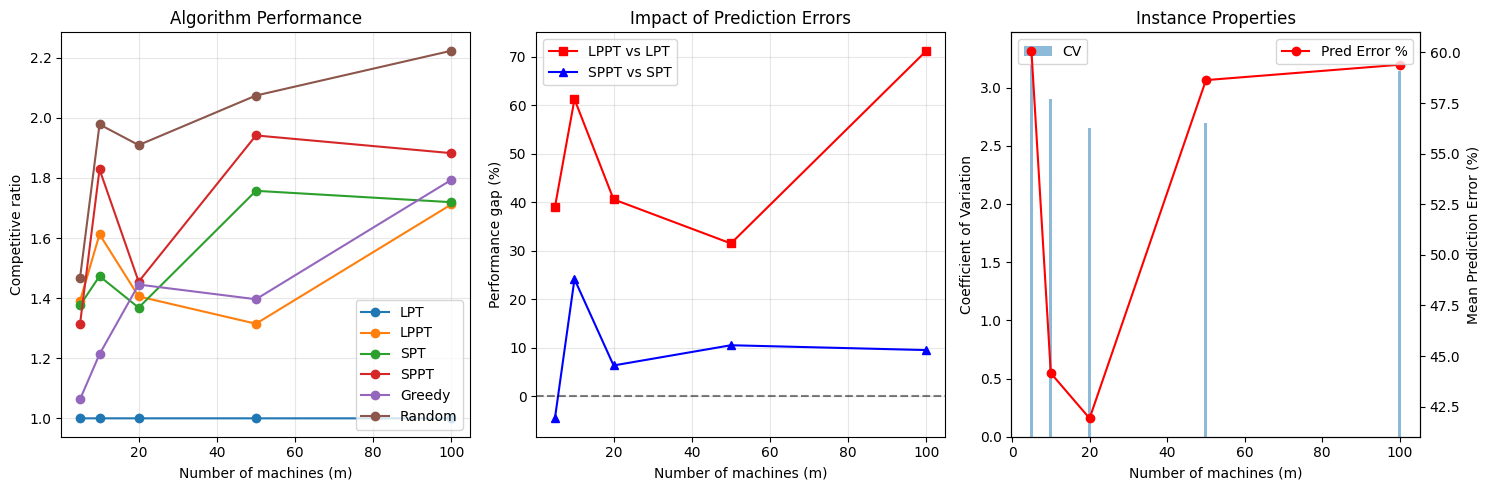


Results saved to 'makespan_results.csv'

MAKESPAN ANALYSIS COMPLETE


In [ ]:

# STANDALONE MAKESPAN EVALUATION - PUBLICATION VERSION
# Run this AFTER your 7-method prediction code


from dataclasses import dataclass
from typing import List, Dict, Tuple
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

@dataclass
class Job:
    job_id: int
    true_size: float
    pred_size: float

    def __post_init__(self):
        self.pred_size = max(self.pred_size, 1e-9)
        self.true_size = max(self.true_size, 1e-9)

# --------------- Core Algorithms ---------------

def makespan_LPT(jobs: List[Job], m: int, use_predictions: bool = False) -> Tuple[float, List[List[int]]]:
    """
    Longest Processing Time First
    Returns: (makespan, assignment)
    """
    if not jobs or m <= 0:
        return 0.0, []

    key = (lambda j: j.pred_size) if use_predictions else (lambda j: j.true_size)
    sorted_jobs = sorted(jobs, key=key, reverse=True)

    if use_predictions:
        perceived_loads = [0.0] * m
        actual_loads = [0.0] * m
        assignments = [[] for _ in range(m)]

        for job in sorted_jobs:
            min_idx = np.argmin(perceived_loads)
            perceived_loads[min_idx] += job.pred_size
            actual_loads[min_idx] += job.true_size
            assignments[min_idx].append(job.job_id)

        return max(actual_loads), assignments
    else:
        loads = [0.0] * m
        assignments = [[] for _ in range(m)]

        for job in sorted_jobs:
            min_idx = np.argmin(loads)
            loads[min_idx] += job.true_size
            assignments[min_idx].append(job.job_id)

        return max(loads), assignments

def makespan_SPT(jobs: List[Job], m: int, use_predictions: bool = False) -> Tuple[float, List[List[int]]]:
    """
    Shortest Processing Time First
    """
    if not jobs or m <= 0:
        return 0.0, []

    key = (lambda j: j.pred_size) if use_predictions else (lambda j: j.true_size)
    sorted_jobs = sorted(jobs, key=key)

    if use_predictions:
        perceived_loads = [0.0] * m
        actual_loads = [0.0] * m
        assignments = [[] for _ in range(m)]

        for job in sorted_jobs:
            min_idx = np.argmin(perceived_loads)
            perceived_loads[min_idx] += job.pred_size
            actual_loads[min_idx] += job.true_size
            assignments[min_idx].append(job.job_id)

        return max(actual_loads), assignments
    else:
        loads = [0.0] * m
        assignments = [[] for _ in range(m)]

        for job in sorted_jobs:
            min_idx = np.argmin(loads)
            loads[min_idx] += job.true_size
            assignments[min_idx].append(job.job_id)

        return max(loads), assignments

def makespan_greedy(jobs: List[Job], m: int) -> Tuple[float, List[List[int]]]:
    """
    Simple greedy: assign each job to currently least loaded machine (no sorting)
    """
    if not jobs or m <= 0:
        return 0.0, []

    loads = [0.0] * m
    assignments = [[] for _ in range(m)]

    for job in jobs:
        min_idx = np.argmin(loads)
        loads[min_idx] += job.true_size
        assignments[min_idx].append(job.job_id)

    return max(loads), assignments

def makespan_random(jobs: List[Job], m: int, seed: int = 42) -> Tuple[float, List[List[int]]]:
    """
    Random assignment
    """
    if not jobs or m <= 0:
        return 0.0, []

    np.random.seed(seed)
    loads = [0.0] * m
    assignments = [[] for _ in range(m)]

    for job in jobs:
        idx = np.random.randint(m)
        loads[idx] += job.true_size
        assignments[idx].append(job.job_id)

    return max(loads), assignments

# --------------- Helper Functions ---------------

def compute_lower_bound(jobs: List[Job], m: int) -> float:
    """McNaughton's bound (optimal preemptive makespan)"""
    if not jobs or m <= 0:
        return 0.0
    total = sum(j.true_size for j in jobs)
    mx = max(j.true_size for j in jobs)
    return max(total / m, mx)

def analyze_instance(jobs: List[Job], m: int) -> Dict:
    """Compute instance characteristics"""
    if not jobs:
        return {}

    sizes = np.array([j.true_size for j in jobs])
    preds = np.array([j.pred_size for j in jobs])

    n = len(jobs)
    total_work = np.sum(sizes)
    avg_load = total_work / m

    pred_errors = np.abs(sizes - preds) / np.maximum(sizes, 1e-9)
    cv = np.std(sizes) / np.mean(sizes) if np.mean(sizes) > 0 else 0

    return {
        'n_jobs': n,
        'jobs_per_machine': n / m,
        'cv': cv,
        'mean_pred_error': np.mean(pred_errors) * 100,
        'median_pred_error': np.median(pred_errors) * 100,
        'max_size': np.max(sizes),
        'avg_load': avg_load
    }

def sample_instances(df: pd.DataFrame, idx_te: np.ndarray, y_pred: np.ndarray,
                     m: int, n_samples: int = None) -> List[Job]:
    """
    Sample jobs from test set
    """
    test_df = df.loc[idx_te].copy().reset_index(drop=True)
    test_df['y_pred'] = y_pred[:len(test_df)]

    if n_samples is None:
        n_samples = min(len(test_df), m * max(10, int(np.log2(m) * 10)))

    if len(test_df) > n_samples:
        sampled = test_df.sample(n=n_samples, replace=False, random_state=42)
    else:
        sampled = test_df

    jobs = []
    for _, row in sampled.iterrows():
        jobs.append(Job(
            job_id=len(jobs),
            true_size=float(row['p_star']),
            pred_size=float(row['y_pred'])
        ))

    return jobs

# --------------- Main Evaluation ---------------

def evaluate_makespan_standalone(machine_counts: List[int] = [5, 10, 20, 50, 100],
                                n_random_trials: int = 10,
                                verbose: bool = True) -> pd.DataFrame:
    """
    Main evaluation function using pre-computed predictions
    """
    # Check for required variables from 7-method code
    if 'df' not in globals():
        raise NameError("ERROR: 'df' not found. Please run 7-method prediction code first.")
    if 'idx_te' not in globals():
        raise NameError("ERROR: 'idx_te' not found. Please run 7-method prediction code first.")
    if 'predictions' not in globals():
        raise NameError("ERROR: 'predictions' not found. Please run 7-method prediction code first.")

    # Select which method's predictions to use
    method_to_use = "M5"  # Options: M1, M3, M4, M5, M6, M7

    if method_to_use not in predictions:
        available = list(predictions.keys())
        print(f"Method {method_to_use} not found. Available: {available}")
        if available:
            method_to_use = available[0]
            print(f"Using {method_to_use} instead")
        else:
            raise ValueError("No predictions available")

    y_pred = predictions[method_to_use]

    print("="*70)
    print(f"MAKESPAN MINIMIZATION EVALUATION - Using {method_to_use}")
    print("="*70)

    results = []

    for m in machine_counts:
        if verbose:
            print(f"\nEvaluating m={m} machines...")

        # Sample instances
        jobs = sample_instances(df, idx_te, y_pred, m)

        # Analyze instance
        stats = analyze_instance(jobs, m)

        # Compute lower bound
        opt_pre = compute_lower_bound(jobs, m)

        # Run algorithms
        t0 = time.time()

        # Oracle algorithms
        lpt_makespan, _ = makespan_LPT(jobs, m, use_predictions=False)
        spt_makespan, _ = makespan_SPT(jobs, m, use_predictions=False)

        # Predicted algorithms
        lppt_makespan, _ = makespan_LPT(jobs, m, use_predictions=True)
        sppt_makespan, _ = makespan_SPT(jobs, m, use_predictions=True)

        # Baseline algorithms
        greedy_makespan, _ = makespan_greedy(jobs, m)

        # Random (average over trials)
        random_makespans = [makespan_random(jobs, m, seed=i)[0]
                           for i in range(n_random_trials)]
        random_makespan = np.mean(random_makespans)

        runtime = time.time() - t0

        # Store results
        result = {
            'm': m,
            'n_jobs': stats['n_jobs'],
            'jobs_per_machine': stats['jobs_per_machine'],
            'cv': stats['cv'],
            'mean_pred_error_%': stats['mean_pred_error'],
            'OPT_pre': opt_pre,

            # Oracle algorithms
            'LPT_makespan': lpt_makespan,
            'LPT_ratio': lpt_makespan / opt_pre if opt_pre > 0 else float('inf'),
            'SPT_makespan': spt_makespan,
            'SPT_ratio': spt_makespan / opt_pre if opt_pre > 0 else float('inf'),

            # Predicted algorithms
            'LPPT_makespan': lppt_makespan,
            'LPPT_ratio': lppt_makespan / opt_pre if opt_pre > 0 else float('inf'),
            'SPPT_makespan': sppt_makespan,
            'SPPT_ratio': sppt_makespan / opt_pre if opt_pre > 0 else float('inf'),

            # Baselines
            'Greedy_makespan': greedy_makespan,
            'Greedy_ratio': greedy_makespan / opt_pre if opt_pre > 0 else float('inf'),
            'Random_makespan': random_makespan,
            'Random_ratio': random_makespan / opt_pre if opt_pre > 0 else float('inf'),

            # Performance gaps
            'LPPT_vs_LPT': (lppt_makespan - lpt_makespan) / lpt_makespan * 100 if lpt_makespan > 0 else 0,
            'SPPT_vs_SPT': (sppt_makespan - spt_makespan) / spt_makespan * 100 if spt_makespan > 0 else 0,

            'runtime_sec': runtime
        }
        results.append(result)

        if verbose:
            print(f"  Jobs: {stats['n_jobs']}, CV: {stats['cv']:.2f}")
            print(f"  Mean prediction error: {stats['mean_pred_error']:.1f}%")
            print(f"  OPT_pre: {opt_pre:.0f}")
            print(f"  LPT:    {lpt_makespan:.0f} (ratio: {lpt_makespan/opt_pre:.3f})")
            print(f"  LPPT:   {lppt_makespan:.0f} (ratio: {lppt_makespan/opt_pre:.3f})")
            print(f"  Greedy: {greedy_makespan:.0f} (ratio: {greedy_makespan/opt_pre:.3f})")
            print(f"  Random: {random_makespan:.0f} (ratio: {random_makespan/opt_pre:.3f})")

    return pd.DataFrame(results)

def plot_results(results_df: pd.DataFrame):
    """Create publication-ready plots"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot 1: Competitive ratios vs m
    ax = axes[0]
    for alg in ['LPT', 'LPPT', 'SPT', 'SPPT', 'Greedy', 'Random']:
        ax.plot(results_df['m'], results_df[f'{alg}_ratio'],
                marker='o', label=alg)
    ax.set_xlabel('Number of machines (m)')
    ax.set_ylabel('Competitive ratio')
    ax.set_title('Algorithm Performance')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Plot 2: Prediction impact
    ax = axes[1]
    ax.plot(results_df['m'], results_df['LPPT_vs_LPT'],
            marker='s', label='LPPT vs LPT', color='red')
    ax.plot(results_df['m'], results_df['SPPT_vs_SPT'],
            marker='^', label='SPPT vs SPT', color='blue')
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax.set_xlabel('Number of machines (m)')
    ax.set_ylabel('Performance gap (%)')
    ax.set_title('Impact of Prediction Errors')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Plot 3: Instance characteristics
    ax = axes[2]
    ax2 = ax.twinx()
    ax.bar(results_df['m'], results_df['cv'], alpha=0.5, label='CV')
    ax2.plot(results_df['m'], results_df['mean_pred_error_%'],
             marker='o', color='red', label='Pred Error %')
    ax.set_xlabel('Number of machines (m)')
    ax.set_ylabel('Coefficient of Variation')
    ax2.set_ylabel('Mean Prediction Error (%)')
    ax.set_title('Instance Properties')
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')

    plt.tight_layout()
    return fig

# --------------- Run Complete Pipeline ---------------

def run_makespan_analysis():
    """Run the complete evaluation pipeline"""

    # Run evaluation
    results_df = evaluate_makespan_standalone(
        machine_counts=[5, 10, 20, 50, 100],
        n_random_trials=10,
        verbose=True
    )

    # Print summary statistics
    print("\n" + "="*70)
    print("SUMMARY STATISTICS")
    print("="*70)

    print("\nAverage Competitive Ratios:")
    for alg in ['LPT', 'LPPT', 'SPT', 'SPPT', 'Greedy', 'Random']:
        mean_ratio = results_df[f'{alg}_ratio'].mean()
        std_ratio = results_df[f'{alg}_ratio'].std()
        print(f"  {alg:8s}: {mean_ratio:.3f} ± {std_ratio:.3f}")

    print("\nAverage Performance Gaps (predicted vs oracle):")
    lppt_gap = results_df['LPPT_vs_LPT'].mean()
    sppt_gap = results_df['SPPT_vs_SPT'].mean()
    print(f"  LPPT vs LPT: {lppt_gap:.1f}%")
    print(f"  SPPT vs SPT: {sppt_gap:.1f}%")

    # Create plots
    try:
        fig = plot_results(results_df)
        plt.show()
    except Exception as e:
        print(f"Could not create plots: {e}")
        fig = None

    # Save results
    results_df.to_csv('makespan_results.csv', index=False)
    print("\nResults saved to 'makespan_results.csv'")

    return results_df, fig

# ============================================================
# EXECUTE ANALYSIS
# ============================================================

if __name__ == "__main__":
    # This will run automatically when you execute this script
    results_df, fig = run_makespan_analysis()

    print("\n" + "="*70)
    print("MAKESPAN ANALYSIS COMPLETE")
    print("="*70)

In [ ]:

# STANDALONE TOTAL COMPLETION TIME ANALYSIS
# Run this AFTER your 7-method prediction code


import numpy as np
import pandas as pd
import heapq
from dataclasses import dataclass
from typing import List, Dict, Tuple, Optional


EPS = 1e-12

@dataclass
class Job:
    job_id: int
    arrival_time: float  # r_j
    true_size: float     # p*_j
    predicted_size: float  # \hat p_j

def build_jobs_from_df(scheduling_df: pd.DataFrame, sample_size: Optional[int] = None) -> List[Job]:
    df = scheduling_df.sort_values('submit_time').reset_index(drop=True)
    if sample_size is not None:
        sample_size = min(sample_size, len(df))
        df = df.iloc[:sample_size].copy()
    jobs: List[Job] = [
        Job(
            job_id=int(row.job_id),
            arrival_time=float(row.submit_time),
            true_size=float(row.p_star),
            predicted_size=float(row.y_pred),
        )
        for row in df.itertuples(index=False)
    ]
    return jobs



def simulate_srpt(jobs: List[Job]) -> Tuple[float, pd.DataFrame]:
    """
    Optimal single-machine ΣC_j with release times: SRPT (preemptive).
    """
    J = sorted(jobs, key=lambda x: x.arrival_time)
    n = len(J)
    i = 0
    t = 0.0
    totalC = 0.0
    metrics = []
    ready: List[Tuple[float, float, int, Job]] = []

    while i < n or ready:
        if not ready and i < n and t < J[i].arrival_time:
            t = J[i].arrival_time
        while i < n and J[i].arrival_time <= t + EPS:
            heapq.heappush(ready, (J[i].true_size, J[i].arrival_time, J[i].job_id, J[i]))
            i += 1

        if not ready:
            continue

        rem, rj, jid, job = heapq.heappop(ready)
        next_arrival = J[i].arrival_time if i < n else float('inf')
        run = min(rem, next_arrival - t)
        if run <= EPS:
            heapq.heappush(ready, (rem, rj, jid, job))
            t = next_arrival
            continue

        t += run
        rem -= run
        if rem <= EPS:
            Cj = t
            totalC += Cj
            metrics.append({
                'job_id': jid,
                'arrival_time': rj,
                'completion_time': Cj,
                'flow_time': Cj - rj,
                'wait_time': Cj - rj - job.true_size,
                'slowdown': (Cj - rj) / max(job.true_size, EPS),
            })
        else:
            heapq.heappush(ready, (rem, rj, jid, job))

    return totalC, pd.DataFrame(metrics)

def simulate_fifo(jobs: List[Job]) -> Tuple[float, pd.DataFrame]:
    """
    FIFO (non-preemptive). Processes jobs by arrival order.
    """
    J = sorted(jobs, key=lambda x: x.arrival_time)
    t = 0.0
    totalC = 0.0
    metrics = []
    for job in J:
        if t < job.arrival_time:
            t = job.arrival_time
        start = t
        t += job.true_size
        Cj = t
        totalC += Cj
        metrics.append({
            'job_id': job.job_id,
            'arrival_time': job.arrival_time,
            'completion_time': Cj,
            'flow_time': Cj - job.arrival_time,
            'wait_time': start - job.arrival_time,
            'slowdown': (Cj - job.arrival_time) / max(job.true_size, EPS),
        })
    return totalC, pd.DataFrame(metrics)

def simulate_sjf_or_spjf(jobs: List[Job], use_predictions: bool) -> Tuple[float, pd.DataFrame]:
    """
    Non-preemptive SJF (oracle, true sizes) or SPJF (predicted sizes).
    """
    J = sorted(jobs, key=lambda x: x.arrival_time)
    n = len(J)
    i = 0
    t = 0.0
    totalC = 0.0
    metrics = []
    ready: List[Tuple[float, float, int, Job]] = []

    while i < n or ready:
        if not ready and i < n and t < J[i].arrival_time:
            t = J[i].arrival_time
        while i < n and J[i].arrival_time <= t + EPS:
            key = J[i].predicted_size if use_predictions else J[i].true_size
            heapq.heappush(ready, (key, J[i].arrival_time, J[i].job_id, J[i]))
            i += 1
        if not ready:
            continue

        _, rj, jid, job = heapq.heappop(ready)
        start = t
        t += job.true_size
        Cj = t
        totalC += Cj
        metrics.append({
            'job_id': jid,
            'arrival_time': rj,
            'completion_time': Cj,
            'flow_time': Cj - rj,
            'wait_time': start - rj,
            'slowdown': (Cj - rj) / max(job.true_size, EPS),
        })
    return totalC, pd.DataFrame(metrics)

def simulate_rr(jobs: List[Job]) -> Tuple[float, pd.DataFrame]:
    """
    Round Robin (equal sharing among active jobs), preemptive.
    """
    J = sorted(jobs, key=lambda x: x.arrival_time)
    n = len(J)
    i = 0
    t = 0.0
    totalC = 0.0
    metrics = []
    active: List[Tuple[Job, float]] = []

    while i < n or active:
        if not active and i < n and t < J[i].arrival_time:
            t = J[i].arrival_time
        while i < n and J[i].arrival_time <= t + EPS:
            active.append((J[i], J[i].true_size))
            i += 1
        if not active:
            continue

        k = len(active)
        rate = 1.0 / k
        time_to_finish = min(rem / rate for (_, rem) in active)
        next_arrival = J[i].arrival_time if i < n else float('inf')
        dt = min(time_to_finish, next_arrival - t)
        t += dt
        finished_idx = []
        for idx, (job, rem) in enumerate(active):
            rem_new = rem - rate * dt
            active[idx] = (job, rem_new)
            if rem_new <= EPS and dt == time_to_finish:
                finished_idx.append(idx)
        for idx in reversed(finished_idx):
            job, _ = active.pop(idx)
            Cj = t
            totalC += Cj
            metrics.append({
                'job_id': job.job_id,
                'arrival_time': job.arrival_time,
                'completion_time': Cj,
                'flow_time': Cj - job.arrival_time,
                'wait_time': Cj - job.arrival_time - job.true_size,
                'slowdown': (Cj - job.arrival_time) / max(job.true_size, EPS),
            })

    return totalC, pd.DataFrame(metrics)

def simulate_prr(jobs: List[Job], lam: float = 0.6) -> Tuple[float, pd.DataFrame]:
    """
    Preferential Round-Robin (PRR) for ΣC_j.
    """
    assert 0.0 < lam < 1.0
    J = sorted(jobs, key=lambda x: x.arrival_time)
    n = len(J)
    i = 0
    t = 0.0
    totalC = 0.0
    metrics = []
    active: List[Tuple[Job, float]] = []

    while i < n or active:
        if not active and i < n and t < J[i].arrival_time:
            t = J[i].arrival_time
        while i < n and J[i].arrival_time <= t + EPS:
            active.append((J[i], J[i].true_size))
            i += 1
        if not active:
            continue

        k = len(active)
        min_idx = min(range(k), key=lambda idx: active[idx][0].predicted_size)
        base = (1.0 - lam) / k
        rates = [base] * k
        rates[min_idx] += lam

        time_to_finish = min(rem / max(rates[idx], EPS) for idx, (_, rem) in enumerate(active))
        next_arrival = J[i].arrival_time if i < n else float('inf')
        dt = min(time_to_finish, next_arrival - t)
        t += dt
        finished_idx = []
        for idx, (job, rem) in enumerate(active):
            rem_new = rem - rates[idx] * dt
            active[idx] = (job, rem_new)
            if rem_new <= EPS and dt == time_to_finish:
                finished_idx.append(idx)
        for idx in reversed(finished_idx):
            job, _ = active.pop(idx)
            Cj = t
            totalC += Cj
            metrics.append({
                'job_id': job.job_id,
                'arrival_time': job.arrival_time,
                'completion_time': Cj,
                'flow_time': Cj - job.arrival_time,
                'wait_time': Cj - job.arrival_time - job.true_size,
                'slowdown': (Cj - job.arrival_time) / max(job.true_size, EPS),
            })

    return totalC, pd.DataFrame(metrics)



def evaluate_total_completion_standalone(sample_size: Optional[int] = 10000,
                                        lambda_values: List[float] = [0.3, 0.5, 0.6, 0.7],
                                        method_to_use: str = "M5") -> Dict[str, Dict]:
    """
    Standalone evaluation using pre-computed predictions from 7-method code
    """
    # Check for required variables
    if 'df' not in globals():
        raise NameError("ERROR: 'df' not found. Please run 7-method prediction code first.")
    if 'idx_te' not in globals():
        raise NameError("ERROR: 'idx_te' not found. Please run 7-method prediction code first.")
    if 'predictions' not in globals():
        raise NameError("ERROR: 'predictions' not found. Please run 7-method prediction code first.")

    # Select method's predictions
    if method_to_use not in predictions:
        available = list(predictions.keys())
        print(f"Method {method_to_use} not found. Available: {available}")
        if available:
            method_to_use = available[0]
            print(f"Using {method_to_use} instead")
        else:
            raise ValueError("No predictions available")

    y_pred = predictions[method_to_use]

    print(f"Using predictions from {method_to_use}")

    # Prepare test dataframe
    test_df = df.loc[idx_te].copy().reset_index(drop=True)
    test_df['y_pred'] = y_pred[:len(test_df)]

    # Normalize submit times to start at 0
    test_df = test_df.sort_values('submit_time').reset_index(drop=True)
    t0 = float(test_df['submit_time'].min())
    test_df['submit_time'] = test_df['submit_time'] - t0

    # Keep only needed columns
    scheduling_df = test_df[['submit_time', 'p_star', 'y_pred']].copy()
    scheduling_df['job_id'] = np.arange(len(scheduling_df))

    jobs = build_jobs_from_df(scheduling_df, sample_size=sample_size)

    results = {}

    # SRPT (optimal)
    srpt_total, srpt_metrics = simulate_srpt(jobs)
    results['SRPT'] = {
        'total_completion': srpt_total,
        'avg_completion': float(srpt_metrics['flow_time'].mean()),
        'avg_wait': float(srpt_metrics['wait_time'].mean()),
        'avg_slowdown': float(srpt_metrics['slowdown'].mean()),
        'metrics': srpt_metrics,
    }

    # FIFO
    fifo_total, fifo_metrics = simulate_fifo(jobs)
    results['FIFO'] = {
        'total_completion': fifo_total,
        'avg_completion': float(fifo_metrics['flow_time'].mean()),
        'avg_wait': float(fifo_metrics['wait_time'].mean()),
        'avg_slowdown': float(fifo_metrics['slowdown'].mean()),
        'metrics': fifo_metrics,
    }

    # SJF (oracle)
    sjf_total, sjf_metrics = simulate_sjf_or_spjf(jobs, use_predictions=False)
    results['SJF'] = {
        'total_completion': sjf_total,
        'avg_completion': float(sjf_metrics['flow_time'].mean()),
        'avg_wait': float(sjf_metrics['wait_time'].mean()),
        'avg_slowdown': float(sjf_metrics['slowdown'].mean()),
        'metrics': sjf_metrics,
    }

    # SPJF (predictions)
    spjf_total, spjf_metrics = simulate_sjf_or_spjf(jobs, use_predictions=True)
    results['SPJF'] = {
        'total_completion': spjf_total,
        'avg_completion': float(spjf_metrics['flow_time'].mean()),
        'avg_wait': float(spjf_metrics['wait_time'].mean()),
        'avg_slowdown': float(spjf_metrics['slowdown'].mean()),
        'metrics': spjf_metrics,
    }

    # RR (equal sharing)
    rr_total, rr_metrics = simulate_rr(jobs)
    results['RR'] = {
        'total_completion': rr_total,
        'avg_completion': float(rr_metrics['flow_time'].mean()),
        'avg_wait': float(rr_metrics['wait_time'].mean()),
        'avg_slowdown': float(rr_metrics['slowdown'].mean()),
        'metrics': rr_metrics,
    }

    # PRR for several λ values
    best_label = None
    best_total = float('inf')
    for lam in lambda_values:
        prr_total, prr_metrics = simulate_prr(jobs, lam=lam)
        label = f'PRR(λ={lam:.2f})'
        results[label] = {
            'total_completion': prr_total,
            'avg_completion': float(prr_metrics['flow_time'].mean()),
            'avg_wait': float(prr_metrics['wait_time'].mean()),
            'avg_slowdown': float(prr_metrics['slowdown'].mean()),
            'metrics': prr_metrics,
        }
        if prr_total < best_total:
            best_total = prr_total
            best_label = label

    # Compute competitive ratios
    srpt_total = results['SRPT']['total_completion']
    fifo_total = results['FIFO']['total_completion']
    for k, v in results.items():
        v['ratio_vs_opt'] = v['total_completion'] / srpt_total if srpt_total > 0 else float('inf')
        v['ratio_vs_fifo'] = v['total_completion'] / fifo_total if fifo_total > 0 else 0

    # Print results
    print("\n" + "="*72)
    n_jobs = len(jobs)
    print(f"Scheduling evaluation on test split (n={n_jobs})  [ΣC_j]")
    print("-"*72)
    header = f"{'Policy':8s} {'ΣC_j':>16s} {'Avg C':>12s} {'ratio/OPT':>10s} {'ratio/FIFO':>11s}"
    print(header)
    for name in ['SRPT', 'SPJF', 'SJF', 'PRR(λ=0.60)', best_label, 'RR', 'FIFO']:
        if name and name in results:
            r = results[name]
            print(f"{name:8s} {r['total_completion']:16.3f} {r['avg_completion']:12.3f} "
                  f"{r['ratio_vs_opt']:10.4f} {r['ratio_vs_fifo']:11.4f}")
    print("="*72)
    if best_label:
        print(f"Best PRR among scanned λ: {best_label} (ratio/OPT={results[best_label]['ratio_vs_opt']:.4f})")

    return results



def compare_methods_total_completion(sample_size: Optional[int] = 10000):
    """
    Compare total completion time performance across all prediction methods
    """
    if 'predictions' not in globals():
        raise NameError("ERROR: 'predictions' not found. Please run 7-method prediction code first.")

    comparison = {}

    for method in predictions.keys():
        print(f"\n{'='*72}")
        print(f"Evaluating with {method} predictions")
        print(f"{'='*72}")

        results = evaluate_total_completion_standalone(
            sample_size=sample_size,
            method_to_use=method
        )

        comparison[method] = {
            'SPJF_ratio': results['SPJF']['ratio_vs_opt'],
            'SJF_ratio': results['SJF']['ratio_vs_opt'],
            'best_PRR_ratio': min([v['ratio_vs_opt'] for k, v in results.items() if k.startswith('PRR')])
        }

    # Print comparison table
    print("\n" + "="*72)
    print("COMPARISON ACROSS PREDICTION METHODS")
    print("="*72)
    print(f"{'Method':<20} {'SPJF ratio':>12} {'SJF ratio':>12} {'Best PRR':>12}")
    print("-"*56)
    for method, metrics in comparison.items():
        print(f"{method:<20} {metrics['SPJF_ratio']:12.4f} {metrics['SJF_ratio']:12.4f} "
              f"{metrics['best_PRR_ratio']:12.4f}")

    return comparison



if __name__ == "__main__":
    # Run with default settings
    results = evaluate_total_completion_standalone(sample_size=10000)

    # Optional: compare across all methods
    # comparison = compare_methods_total_completion(sample_size=10000)

    print("\n" + "="*72)
    print("TOTAL COMPLETION TIME ANALYSIS COMPLETE")
    print("="*72)

Using predictions from M5

Scheduling evaluation on test split (n=10000)  [ΣC_j]
------------------------------------------------------------------------
Policy               ΣC_j        Avg C  ratio/OPT  ratio/FIFO
SRPT      49096028164.000  4578133.746     1.0000      0.1861
SPJF      52444771849.000  4913008.114     1.0682      0.1988
SJF       49158440959.000  4584375.025     1.0013      0.1864
PRR(λ=0.60)  64976398135.134  6166170.743     1.3235      0.2463
PRR(λ=0.70)  61255483828.172  5794079.312     1.2477      0.2322
RR        96948498573.147  9363380.786     1.9747      0.3676
FIFO     263767978215.000 26045328.751     5.3725      1.0000
Best PRR among scanned λ: PRR(λ=0.70) (ratio/OPT=1.2477)

TOTAL COMPLETION TIME ANALYSIS COMPLETE
